# National Hockey League Analytics: A study on Alex Ovechkin
#### Brian Lee


![ovi_2010.jpg](ovi_2010.jpg)

When defining a "generationally talented" player in The National Hockey League, only an exceptional few players can truly meet the criteria: players that essentially reinvent the game of hockey with their strength, skills, and smarts. Looking through previous generations of hockey, longtime fans and analysts alike would point to the likes of Bobby Orr, Patrick Roy, Pavel Datsyuk, Jaromir Jagr, and most famously Wayne Gretzky, who currently holds 61 National Hockey League records.

Current generational talents, whose careers are still in progress, are difficult to identify. These exceptional players are so revered that even fans of rival teams often hold them in respect and reverence. Among them are Sidney Crosby of the Pittsburgh Penguins, Connor McDavid of the Edmonton Oilers, and my personal favorite, Alex Ovechkin of the Washington Capitals. Alex Ovechkin, who was drafted by the Capitals in 2005, quickly caught the public eye with his high-energy and high-skill gameplay. Capable of hitting as hard as he shot, he stands as a founder of the archetype of the modern hockey player.

![ovi_2017.jpg](ovi_2017.jpg)

However, that is not to say Alex Ovechkin's all-time greatness has not been in question. Despite leading efforts in all postseasons, Ovechkin experienced nothing but crushing defeats in the playoffs, never breaking through past the second of four rounds it takes to win the Stanley Cup. The disappointment was at its peak after an early exit from the 2017 playoffs, during which he was surrounded by arguably his most talented team yet. Although he went onto achieve the greatest feat in hockey, winning a Stanley Cup chapmionship with 16 goals and 8 assists, the discourse was still there and it was loud.
Many not only blamed his lack of success on his laziness and selfishness, but also blamed his style of play, which involves shooting the puck and his utilizing his goal-scoring ability. 

Through an exploration of real game data, I wish to dispel notion that he is nothing short of a generationally talented player. My objectives are to demonstrate just how unparalleled his ability to score goals is to any other player in the league and analyze the strength of this unique contribution to the Washington Capitals. My future goals would be to construct a model that, given data about his goals scored, can accurately classify whether an Alex Ovechkin shot would result in a goal.

![ovi_2018.jpg](ovi_2018.jpg)



In [52]:
# Install a pip package in the current Jupyter kernel if not yet installed locally.
import sys
!python -m pip install hockey_rink

# Install other Python packages.
import requests as req
import json
import numpy as np
import math
from hockey_rink import NHLRink
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from PIL import Image
import matplotlib.lines as mlines
from matplotlib.patches import RegularPolygon
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors


In [53]:
#Initialize dictionary, variables
games18 = 82 #82 games per season
id = 8471214 #Alex Ovechkin NHLID

leaguewide_stats = {}
leaguewide_stats['Shot'] = {}
leaguewide_stats['Shot']['x'] = []
leaguewide_stats['Shot']['y'] = []
leaguewide_stats['Shot']['time'] = []
leaguewide_stats['Goal'] = {}
leaguewide_stats['Goal']['x'] = []
leaguewide_stats['Goal']['y'] = []
leaguewide_stats['Goal']['time'] = []

player_stats = {}
player_stats['Shot'] = {}
player_stats['Shot']['x'] = []
player_stats['Shot']['y'] = []
player_stats['Shot']['time'] = []
player_stats['Goal'] = {}
player_stats['Goal']['x'] = []
player_stats['Goal']['y'] = []
player_stats['Goal']['time'] = []

#Master function of sorts that stores every play of every game for a player
# in a given year.
def store_year(year, until, searchid):
    end_year = int(year) + 1
    print("Appending data for year " + year + "-" + str(end_year)+ "...")

    for i in range(1, until):
        with open('./'+year+'Data'+'/'+
            year+'_g'+str(i)+'Capitals.json') as file:
            game = json.load(file)
            all_plays = game['liveData']['plays']['allPlays']
            fill_dict(all_plays, searchid)

#Fills the dictionary with all the right plays
def fill_dict(all_plays, searchid):
    for play in all_plays:
        if 'players' in play:
            j = 0

            #Differentiates if a the desired player is part of the play.
            player_list = play['players']
            for player in player_list:
                matchid = player_list[0]['player']['id']
                if searchid == matchid:
                    player_dict = player_stats
                    sort_event(play, player_dict)
                else:
                    player_dict = leaguewide_stats
                    sort_event(play, player_dict)
                j += 1

#Categorizes events based on type, i.e, shot, goal, etc.
def sort_event(play, dict):
    #Initialize for compactness purposes
    xs = dict['Shot']['x']
    ys = dict['Shot']['y']
    ts = dict['Shot']['time']
    xg = dict['Goal']['x']
    yg = dict['Goal']['y']
    tg = dict['Goal']['time']

    event = play["result"]['event'] #The name of type of event
    coordinates = play['coordinates'] #Necessary for special cases of
    #bad data where only one coordinate exists for the event

    if len(coordinates) == 2:
        if event == "Shot":
            xcoord = play['coordinates']['x']
            ycoord = play['coordinates']['y']
            time = play['about']['periodTime']
            xs.append(xcoord)
            ys.append(ycoord)
            ts.append(time)
        elif event == "Goal":
            xcoord = play['coordinates']['x']
            ycoord = play['coordinates']['y']
            time = play['about']['periodTime']
            xg.append(xcoord)
            yg.append(ycoord)
            tg.append(time)


#store_year('2010', 82, id)
#store_year('2011', 82, id)
#store_year('2012', 48, id)
#store_year('2013', 82, id)
#store_year('2016', 82, id)
store_year('2017', 82, id)
store_year('2018', 82, id)
store_year('2019', 82, id)
store_year('2020', 56, id)

Appending data for year 2017-2018...
Appending data for year 2018-2019...
Appending data for year 2019-2020...
Appending data for year 2020-2021...


In [54]:
#Initialize dataframes to use pandas data analysis
player_df = pd.DataFrame(player_stats)
league_df = pd.DataFrame(leaguewide_stats)

league_sog_x = league_df['Shot']['x'] + league_df['Goal']['x']
league_sog_y = league_df['Shot']['y'] + league_df['Goal']['y']
league_sog_t = league_df['Shot']['time'] + league_df['Goal']['time']
player_sog_x = player_df['Shot']['x'] + player_df['Goal']['x']
player_sog_y = player_df['Shot']['y'] + player_df['Goal']['y']
player_sog_t = player_df['Shot']['time'] + player_df['Goal']['time']

#Assumed that goals are added to where shots end. Create list to classify events.
def goalcheck(type_df):
    test = list()
    for i in range(len(type_df['Shot']['x'])):
        test.append(0)
    for i in range(len(type_df['Shot']['x']),
            len(type_df['Shot']['x'] + type_df['Goal']['x'])):
        test.append(1)
    return test
league_goalcheck = goalcheck(league_df)
player_goalcheck = goalcheck(player_df)
league_goalcheck = np.array(league_goalcheck)
player_goalcheck = np.array(player_goalcheck)

def converttime(time_list):
    test = list()
    for i in range(len(time_list)):
        time_split = time_list[i].split(':')
        test.append(60 * int(time_split[0]) + int(time_split[1]))    
    return test

player_sog_t = converttime(player_sog_t)
league_sog_t = converttime(league_sog_t)

#Make new dataframes with a check if the shot is a goal or not
#League
league_sog_x = np.array(league_sog_x)
np.abs(league_sog_x, out=league_sog_x) #Normalize coordinates
league_sog_y = np.array(league_sog_y) #No normalization needed for y
league_g_x = np.abs(np.array(league_df['Goal']['x']))
league_g_y = np.array(league_df['Goal']['y'])

league_sog_df = pd.DataFrame()
league_sog_df['x'] = league_sog_x
league_sog_df['y'] = league_sog_y
league_sog_df['time'] = league_sog_t
league_sog_df['goalcheck'] = league_goalcheck

#Player
player_sog_x = np.array(player_sog_x)
np.abs(player_sog_x, out=player_sog_x)
player_sog_y = np.array(player_sog_y)
player_g_x = np.abs(np.array(player_df['Goal']['x']))
player_g_y = np.array(player_df['Goal']['y'])

player_sog_df = pd.DataFrame()
player_sog_df['x'] = player_sog_x
player_sog_df['y'] = player_sog_y
player_sog_df['time'] = player_sog_t
player_sog_df['goalcheck'] = player_goalcheck

comp_size = len(league_sog_x)/len(player_sog_x)

Now that all of the data is stored in easily accessible and manipulatable Pandas dataframes, we can calculate basic statistics and plot preliminary visualization. This will allow us to see where the data tends as well as how it might be shaped.

These dataframes store data on shots on goal, which includes shot attempts that hit the goalie or enter the goal, while shot attempts that strike the goalposts or miss the net are omitted.

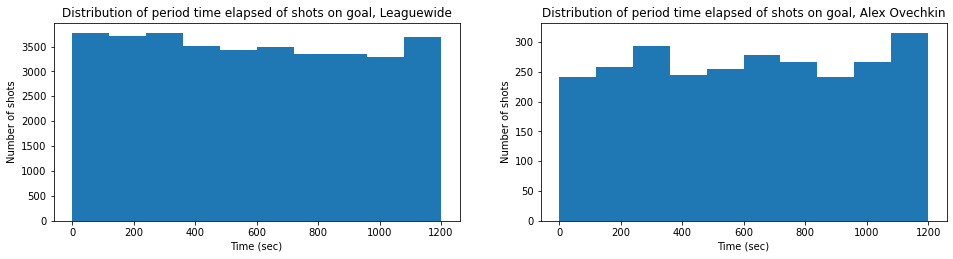

In [55]:
fig = plt.figure(figsize=(16,8))
ax = []
ax.append(fig.add_subplot(221))
ax.append(fig.add_subplot(222))


ax[0].hist(league_sog_df['time'])
ax[0].title.set_text("Distribution of period time elapsed of shots on goal, Leaguewide")
ax[0].set_xlabel("Time (sec)")
ax[0].set_ylabel("Number of shots")

ax[1].hist(player_sog_df['time'])
ax[1].title.set_text("Distribution of period time elapsed of shots on goal, Alex Ovechkin")
ax[1].set_xlabel("Time (sec)")
ax[1].set_ylabel("Number of shots")

plt.show()


Because this scenario exists in three-dimensional space, it is more helpful to visualize the event coordinates for shots and goals as locations on the rink's surface. This is allows us to more finely discern the shape of these shots on more than one axis at once. It would also be helpful to visualize a version of the plot whose values are determiend by whether a shot resulted in a goal or not. 

Luckily, the efforts of GitHub user @the-bucketless have provided an incredibly intuitive package that allows us to draw many types of hockey rinks onto a Matplotlib figure. In addition, there are plotting functions that extend those of Matplotlib to create intresting and presentable visualizations on the rink surface, such as contour plots and heatmaps.

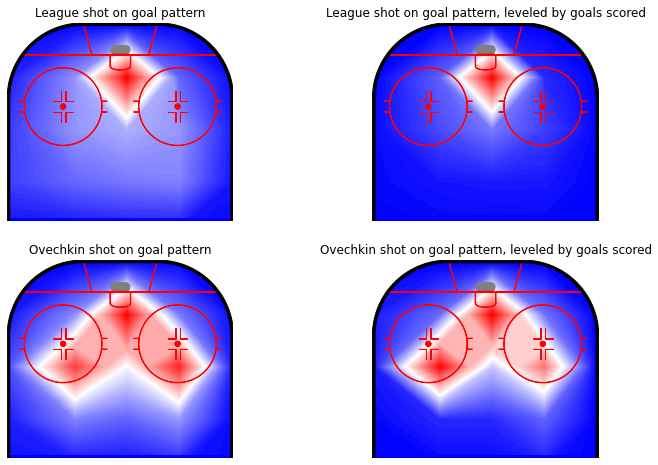

In [56]:
#First figure, for raw shot-goal pattern visualization.
fig = plt.figure(figsize=(12, 8))
ax = []
ax.append(fig.add_subplot(221))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

ax[0].title.set_text("League shot on goal pattern")
ax[1].title.set_text("League shot on goal pattern, leveled by goals scored")
ax[2].title.set_text("Ovechkin shot on goal pattern")
ax[3].title.set_text("Ovechkin shot on goal pattern, leveled by goals scored")
    
rink = NHLRink(rotation=90)
for i in range(4):
    rink.draw(ax=ax[i], display_range="ozone")

#Visualize raw shot-goal patterns
rink.heatmap(league_sog_df.x, league_sog_df.y,
     cmap="magma", ax=ax[0], binsize=2)
rink.heatmap(player_sog_df.x, player_sog_df.y,
    cmap="magma", ax=ax[1], binsize=2)
rink.heatmap(league_sog_df.x, league_sog_df.y,
     cmap="magma", ax=ax[2], binsize=2)
rink.heatmap(player_sog_df.x, player_sog_df.y,
    cmap="magma", ax=ax[3], binsize=2) 
#NOTE: Change order of function calls if heat maps vs. contour plots desired.

rink.contourf(league_sog_df.x, league_sog_df.y,
    ax=ax[0], binsize=20, cmap="bwr", levels=100)
rink.contourf(player_sog_df.x, player_sog_df.y,
    ax=ax[2], binsize=20, cmap="bwr", levels=100)
rink.contourf(league_sog_df.x, league_sog_df.y,
    values=league_sog_df.goalcheck, ax=ax[1], binsize=20, cmap="bwr", levels=100)
rink.contourf(player_sog_df.x, player_sog_df.y,
    values=player_sog_df.goalcheck, ax=ax[3], binsize=20, cmap="bwr", levels=100)


There are some surface-level take-aways we can gain from these simple contour plots. Examining the first two plots, we observe that, across the league, the shots taken are heavily concentrated in front of the net, no more than a meter or two away. This same tendency applies when we measure the levels based on if a goal was scored or not. We can see that goal-scoring success actually strengthens based on the contrast between the "warmer" and "colder" contour patterns.

However, Alex Ovechkin's shot and goal pattern is quite different. Not only does he take more shots from more areas on the ice, such as on the tops of the faceoff circles, but also the goals he scores tend more towards the left circle in particular. It should be noted that conventional hockey education teaches players to shoot close in front of the net for the highest probability. So in a sense, Alex Ovechkin is already defying certain odds with how he is able to score from a wide range of locations, a sharpshooter.

Let us further explore Alex Ovechkin's unconventionality as a shooter by comparing his performance relative to league-wide behavior on the same visualization.

In [57]:
#Initialize project-specific measurements for figures.
bounds = [-100.0, 100.0, -100, 100]
grid = 30
cnt = 0

color_map = plt.cm.winter
positive_cm = ListedColormap([mcolors.ColorConverter().to_rgb('#e1e5e5'),
    mcolors.ColorConverter().to_rgb('#d63b36')])
negative_cm = ListedColormap([mcolors.ColorConverter().to_rgb('#e1e5e5'),
    mcolors.ColorConverter().to_rgb('#28aee4')])

width = 50
height= 50
shiftx = 28
shifty= 25
scalex = width/100*1.25
scaley = height/100*1.8
scalehex = 4.4*scalex

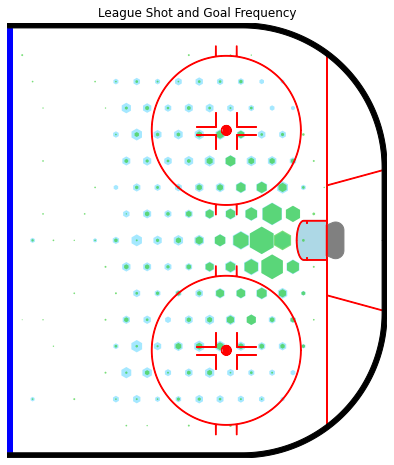

In [58]:
fig_league, ax_league = plt.subplots(1, 1, figsize=(8, 8)) #Save each figure for future analysis
ax_league.title.set_text("League Shot and Goal Frequency")
rink = NHLRink()
rink_league = rink.draw(display_range="ozone")

league_sog_hex = plt.hexbin(league_sog_x, league_sog_y,
    gridsize=grid, extent=bounds, mincnt=cnt, alpha=0)
league_g_hex = plt.hexbin(league_g_x, league_g_y,
    gridsize=grid, extent=bounds, mincnt=cnt, alpha=0)

league_offsets = league_sog_hex.get_offsets()
league_sog_freq = league_sog_hex.get_array()
league_g_offsets = league_g_hex.get_offsets()
league_g_freq = league_g_hex.get_array()

for i,j in enumerate(league_offsets):
    if league_sog_freq[i] < 50: continue
    league_sog_scale = league_sog_freq[i]/max(league_sog_freq)
    radius = scalehex * math.sqrt(league_sog_scale)

    hex = RegularPolygon((shiftx+j[0]*scalex, (height/2)-j[1]*scaley-shifty), numVertices=6,
        radius=radius, orientation=np.radians(0), alpha=0.35, facecolor="deepskyblue")
    rink_league.add_patch(hex)
    
for i,j in enumerate(league_g_offsets):
    if league_sog_freq[i] < 10: continue
    league_g_scale = league_g_freq[i]/max(league_g_freq)
    radius = scalehex * math.sqrt(league_g_scale)

    hex = RegularPolygon((shiftx+j[0]*scalex, (height/2)-j[1]*scaley-shifty), numVertices=6,
        radius=radius, orientation=np.radians(0), alpha=0.65, facecolor="limegreen")
    rink_league.add_patch(hex)

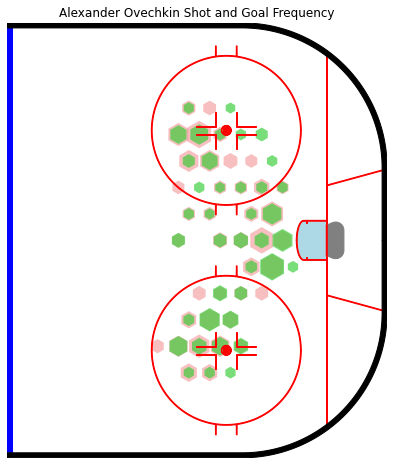

In [59]:
fig_player, ax_player = plt.subplots(1, 1, figsize=(8, 8)) #Save each figure for future analysis
ax_player.title.set_text("Alexander Ovechkin Shot and Goal Frequency")
rink = NHLRink()
rink_player = rink.draw(display_range="ozone")

player_sog_hex = plt.hexbin(player_sog_x, player_sog_y,
    gridsize=grid, extent=bounds, mincnt=cnt, alpha=0)
player_g_hex = plt.hexbin(player_g_x, player_g_y,
    gridsize=grid, extent=bounds, mincnt=cnt, alpha=0)

player_offsets = player_sog_hex.get_offsets()
player_sog_freq = player_sog_hex.get_array()
player_g_offsets = player_g_hex.get_offsets()
player_g_freq = player_g_hex.get_array()

#Visualize where player takes shots
for i,j in enumerate(player_offsets):
    if player_sog_freq[i] < 25: continue
    player_sog_scale = player_sog_freq[i]/max(player_sog_freq)
    radius = scalehex * math.sqrt(player_sog_scale)

    hex = RegularPolygon((shiftx+j[0]*scalex, (height/2)-j[1]*scaley-shifty), numVertices=6,
        radius=radius, orientation=np.radians(0), alpha=0.5, facecolor="lightcoral")
    rink_player.add_patch(hex)

#Visualize where player scores
for i, j in enumerate(player_g_offsets):
    if player_g_freq[i] < 5: continue
    player_g_scale = player_g_freq[i]/max(player_g_freq)
    radius2 = scalehex * math.sqrt(player_g_scale)

    hex2 = RegularPolygon((shiftx+j[0]*scalex, (height/2)-j[1]*scaley-shifty), numVertices=6,
        radius=radius2, orientation=np.radians(0), alpha=0.65, facecolor="limegreen")
    rink_player.add_patch(hex2)

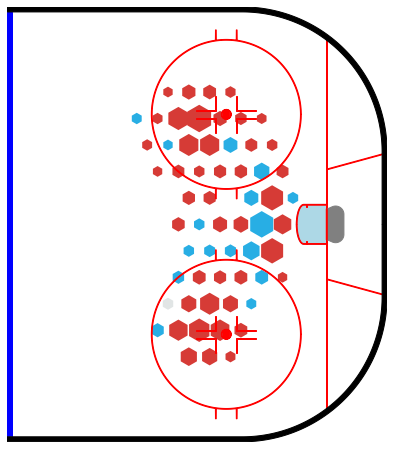

In [62]:
#Compare scoring efficiency of player against league.
league_eff = list()
player_eff = list()
comp_eff = list()

fig_comp, ax_comp = plt.subplots(1, 1, figsize=(8, 8)) #Save each figure for future analysis
rink = NHLRink()
rink_comp = rink.draw(display_range="ozone")

#May not be necessary for final product.
for i in range(0, len(league_sog_freq)):
    if league_sog_freq[i] < 5 or player_sog_freq[i] < 5: continue
    league_eff_local = league_g_freq[i]/league_sog_freq[i]
    player_eff_local = player_g_freq[i]/player_sog_freq[i]

    league_eff.append(league_eff_local)
    player_eff.append(player_eff_local)
    comp_eff.append(player_eff_local-league_eff_local)
    
for i, j in enumerate(player_offsets):
    if player_sog_freq[i] < 15: continue
    player_sog_scale = player_sog_freq[i]/max(player_sog_freq)
    radius3 = scalehex * math.sqrt(player_sog_scale)

    league_eff_local = league_g_freq[i]/league_sog_freq[i]
    player_eff_local = player_g_freq[i]/player_sog_freq[i]
    comp_eff_local = player_eff_local-league_eff_local

    if comp_eff_local > 0:
        colour = positive_cm(math.pow(comp_eff_local, 0.001))
    else:
        colour = negative_cm(math.pow(-comp_eff_local, 0.001))

    hex3 = RegularPolygon((shiftx+j[0]*scalex, (height/2)-j[1]*scaley-shifty), numVertices=6,
        radius=radius3, orientation=np.radians(0), alpha=1.0, facecolor=colour)

    rink_comp.add_patch(hex3)

In [61]:
plt.show()